# Y2H assay version benchmarking

Here, plots are made to investiagte the sensitivity of different Y2H assay versions, using data from repeat pairwise Y2H experiments on the PRS and also the Lit-BM-13 pairs that were included when doing some of the pairwise tests of the screen pairs.

In [1]:
from collections import OrderedDict

import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch

from custom_settings import *
from utils import checkerboard, validation_plot

In [2]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [3]:
prs_rrs = pd.read_csv('../data/processed/Supplementary Table 5.txt', sep='\t')


def collapse_to_pairs(data):
    df = data.copy()
    df['pair'] = (df[['ad_symbol', 'db_symbol']].min(axis=1).astype(str) + '_' +
                  df[['ad_symbol', 'db_symbol']].max(axis=1).astype(str))
    if not (df.groupby(['source', 'assay_version', 'pair']).size() <= 2).all():
        raise UserWarning('Expected 1 or 2 tests of every pair')
        
    def single_score(rows):
        if (rows['score'] == '1').any():
            return 1
        elif (rows['score'] == 'NA').all():
            return np.nan
        else:
            return 0
    return (df.groupby(['source', 'assay_version', 'pair'])
              .apply(single_score)
              .reset_index()
              .rename(columns={0: 'score'}))


prs_rrs = collapse_to_pairs(prs_rrs)
# remove pairs that are NA in any of the assay versions
null_prs = prs_rrs.loc[prs_rrs['score'].isnull(), 'pair'].values
prs_rrs = prs_rrs.loc[~prs_rrs['pair'].isin(null_prs), :]
prs_rrs[['symbol_a', 'symbol_b']] = prs_rrs['pair'].str.split('_', expand=True)
prs = (prs_rrs.loc[(prs_rrs['source'] == 'PRS_V1'), :]
              .pivot(index='pair', columns='assay_version', values='score'))
prs[['symbol_a', 'symbol_b']] = prs.index.to_series().str.split('_', expand=True)
rrs = (prs_rrs.loc[(prs_rrs['source'] == 'RRS_V1'), :]
              .pivot(index='pair', columns='assay_version', values='score'))
rrs[['symbol_a', 'symbol_b']] = rrs.index.to_series().str.split('_', expand=True)

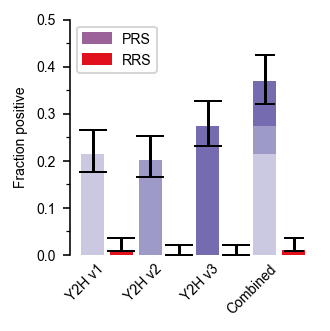

In [4]:
def recovery_plot_with_combined_column(data, prs_source, rrs_source, prs_label='PRS', ymax=1.0, ax=None):
    df = data.copy()
    colors = {'PRS Y2H v1': ASSAY_V1_COLOR,
              'RRS Y2H v1': RRS_COLOR,
              'PRS Y2H v2': ASSAY_V2_COLOR,
              'RRS Y2H v2': RRS_COLOR,
              'PRS Y2H v3': ASSAY_V3_COLOR,
              'RRS Y2H v3': RRS_COLOR}
    categories  = {'PRS Y2H v1': (df['source'] == prs_source) &
                                   (df['assay_version'] == 1),
                     'RRS Y2H v1': (df['source'] == rrs_source) &
                                     (df['assay_version'] == 1),
                     'PRS Y2H v2': (df['source'] == prs_source) &
                                     (df['assay_version'] == 2),
                     'RRS Y2H v2': (df['source'] == rrs_source) &
                                 (df['assay_version'] == 2),
                     'PRS Y2H v3': (df['source'] == prs_source) &
                                 (df['assay_version'] == 3),
                     'RRS Y2H v3': (df['source'] == rrs_source) &
                                     (df['assay_version'] == 3)}
    validation_plot(data=df, 
                    selections=categories.values(),
                    labels=list(categories.keys()),
                    colors=[colors[cat] for cat in categories.keys()],
                    result_column='score',
                    y_max=ymax,
                    draw_numbers=False,
                    ax=ax)
    # draw additional bar for combination
    v1, v2, v3 = (set(df.loc[(df['source'] == prs_source) &
                             (df['assay_version'] == v) &
                             (df['score'] == 1), 'pair'].values)
                  for v in [1, 2, 3])
    n = ((df['source'] == prs_source) & 
         (df['assay_version'] == 1)).sum()
    ax.bar([6], 
           [len(v1) / n],
           color=ASSAY_V1_COLOR)
    ax.bar([6],
           [(len(v1.union(v2)) / n) - (len(v1) / n)], bottom=[len(v1) / n],
           color=ASSAY_V2_COLOR)
    ax.bar([6],
           [(len(v1.union(v2).union(v3)) / n) - (len(v1.union(v2)) / n)], bottom=[len(v1.union(v2)) / n],
           color=ASSAY_V3_COLOR)

    def draw_single_bayesian_error_proportion_bar(x, pos, neg, ax):
        """

        Args:
            x (float): x axis position
            pos (int): number of positives
            neg (int): number of negatives

        """
        f = pos / (pos + neg)
        intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
        err = [f - intv[0], intv[1] - f]
        ax.errorbar([x], 
                    np.array([f]),
                    yerr=np.array([err]).T,
                    color='black', fmt='none', capsize=5.)


    p_lit_combo = len(v1.union(v2).union(v3))
    draw_single_bayesian_error_proportion_bar(6, p_lit_combo, n - p_lit_combo, ax)  
    n_rrs = df.loc[(df['source'] == rrs_source), 'pair'].nunique()
    p_rrs_combo = df.loc[(df['source'] == rrs_source) &
                         (df['score'] == 1),
                         'pair'].nunique()
    f_rrs_combo = p_rrs_combo / n_rrs
    ax.bar([7], 
           [f_rrs_combo],
           color=RRS_COLOR)
    draw_single_bayesian_error_proportion_bar(7, p_rrs_combo, n_rrs - p_rrs_combo, ax)

    ax.set_xticks([0.5, 2.5, 4.5, 6.5])
    ax.set_xticklabels(['Y2H v1', 'Y2H v2', 'Y2H v3', 'Combined'], ha='right')
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_tick_params(length=0.)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # TODO: make the PRS legend have multiple colors
    prs_patch = mpatches.Patch(color=HURI_COLOR, label='PRS')
    prs_patch_1 = mpatches.Patch(color=ASSAY_V1_COLOR, label='PRS')
    prs_patch_2 = mpatches.Patch(color=ASSAY_V2_COLOR, label='PRS')
    prs_patch_3 = mpatches.Patch(color=ASSAY_V3_COLOR, label='PRS')
    rrs_patch = mpatches.Patch(color=RRS_COLOR, label='RRS')
    ax.set_facecolor('1.')
    ax.legend(handles=[prs_patch, rrs_patch],
              labels=[prs_label, 'RRS'],
              loc='upper left', )

    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.3, 2.3)
recovery_plot_with_combined_column(prs_rrs,
                                   'PRS_V1',
                                   'RRS_V1',
                                   ymax=0.5,
                                   ax=ax)
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/prs_recovery_by_assay_versions' + fmt)

In [5]:
prs_rrs.source.value_counts()

RRS_V1    270
PRS_V1    252
Name: source, dtype: int64

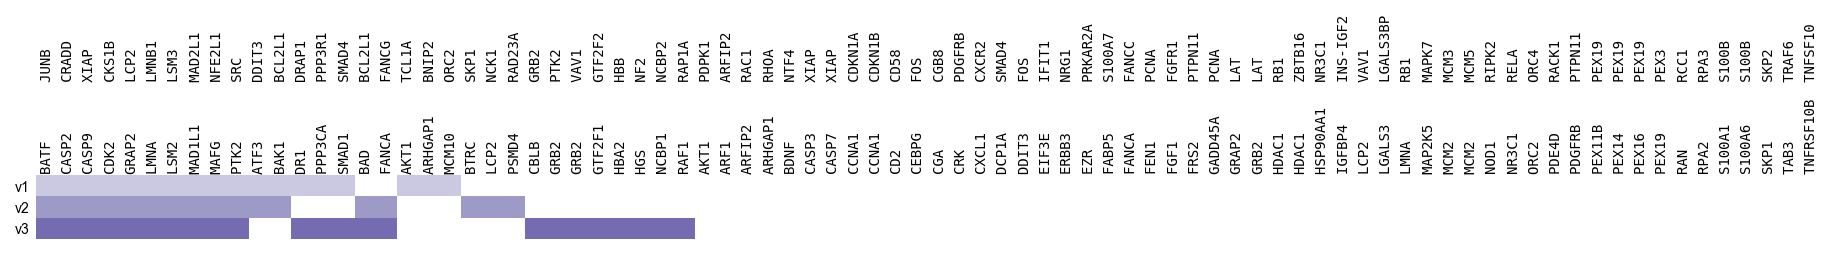

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
checkerboard(prs, 
            detection_columns=[1, 2, 3],
            assay_labels=['v1', 'v2', 'v3'],
            protein_a_column='symbol_a',
            protein_b_column='symbol_b',
            positive_color=[ASSAY_V1_COLOR, ASSAY_V2_COLOR, ASSAY_V3_COLOR],
            ax=ax)
for fmt in FORMATS:
    plt.savefig('../figures/prs_checkerboard' + fmt,
                bbox_inches='tight')

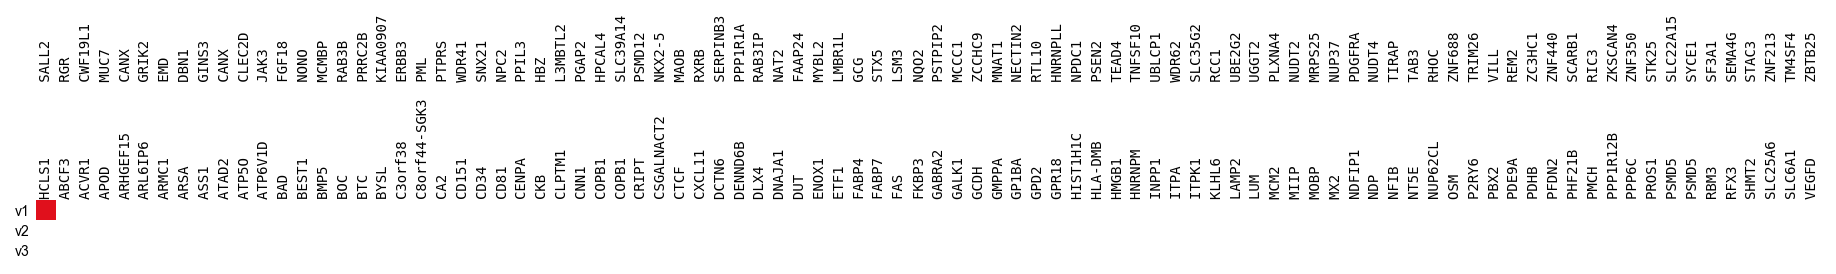

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
checkerboard(rrs, 
             detection_columns=[1, 2, 3],
             assay_labels=['v1', 'v2', 'v3'],
             protein_a_column='symbol_a',
             protein_b_column='symbol_b',
             positive_color=RRS_COLOR,
             ax=ax)
for fmt in FORMATS:
    plt.savefig('../figures/rrs_checkerboard' + fmt,
                bbox_inches='tight')